### Script to generate FATES parameters using LHS

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import modp as mp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import cm


In [2]:
random.seed(32)

#### Read in min and max values for each parameter and pft 

In [3]:
param_ranges_full = pd.read_csv('/global/homes/j/jneedham/FATES-MRV/param_files/PA_param_ranges_3pfts.csv')
param_ranges = param_ranges_full[['param', 'value_min', 'value_max', 'pft', 'organ']]

# number of parameters
n_params = len(param_ranges)

# number of PFTs - some are global so subtract one
n_pfts = len(pd.unique(param_ranges['pft'])) - 1

param_names = list(param_ranges.param)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

print(param_ranges)

                                      param  value_min   value_max  pft  organ
0          fates_maintresp_nonleaf_baserate   0.000002    0.000003    0    NaN
1              fates_mort_understorey_death   0.000000    1.000000    0    NaN
2                   fates_mort_disturb_frac   0.300000    1.000000    0    NaN
3                              fates_grperc   0.100000    0.300000    3    NaN
4                              fates_grperc   0.100000    0.300000    2    NaN
5                              fates_grperc   0.100000    0.400000    1    NaN
6   fates_maintresp_leaf_vert_scaler_coeff2   1.600000    2.430000    3    NaN
7   fates_maintresp_leaf_vert_scaler_coeff2   1.600000    2.430000    2    NaN
8   fates_maintresp_leaf_vert_scaler_coeff2   1.600000    2.430000    1    NaN
9                     fates_leaf_vcmax25top  46.500000   77.500000    3    NaN
10                    fates_leaf_vcmax25top  43.500000   72.500000    2    NaN
11                    fates_leaf_vcmax25top  43.5000

In [4]:
n_inst = 1000

sampler = qmc.LatinHypercube(d=n_params)
sample = sampler.random(n=n_inst)

# scale to parameter ranges
l_bounds = param_ranges['value_min']
u_bounds = param_ranges['value_max']

scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

In [5]:
npft1 = param_ranges['pft'].value_counts().get(1, 0)

print(npft1)

10


In [6]:
rows, cols = n_inst, npft1

df = pd.DataFrame(np.nan, index=range(rows), columns=range(cols))

## Read in defaut FATES file - note that this is the default for FATES but with:
#  two stream radiation
# Atkin respiration
# Updated allometries for Eastern US trees 

input_fname = '/global/homes/j/jneedham/FATES-MRV/param_files/fates_params_PA_3pfts.nc'


# for each sample 
for i in range(0,n_inst) :
    
    # final parameter file name
    fout = '/global/homes/j/jneedham/FATES-MRV/param_files/fates_params_3pfts_pa_ens_{0}.nc'.format(i+1)
    
    shutil.copyfile(input_fname, fout)   
    
    pft1_ind = 0

   
    # loop through each parameter and apply either to the correct pft or globally
    for j in range(0, n_params) : 
        
        ###  If it is a scaled parameter then we multiply the sampled scalar by the
        ### sampled parameter of PFT 2 and apply the result to PFT 1
        ### This ensures that life history trade-offs are implemented
        
        pft = pfts[j]
        organ = organs[j]
        val = scaled_sample[i, j]
        var = param_names[j]
        
        if pft == 1:
            
            if var in ['fates_grperc', 'fates_maintresp_leaf_vert_scaler_coeff2', 
                                'fates_leaf_vcmax25top', 'fates_leaf_slatop', 
                                'fates_mort_bmort', 'fates_mort_scalar_cstarvation', 
                                'fates_recruit_seed_alloc'] : 
            
                minv = scaled_sample[i, j-1]
                maxv = param_ranges['value_max'][j]
            
            else:
                
                maxv = scaled_sample[i, j-1]
                minv = param_ranges['value_min'][j]
            
            pft1val = random.uniform(minv, maxv)
            mp.main(var = var, pft = pft, fin = fout, val = pft1val, 
                    fout = fout, O = 1, organ = organ)
            
            df.iloc[i, pft1_ind] = pft1val
            
            pft1_ind = pft1_ind + 1
        
        
        else:
            mp.main(var = var, pft = pft, fin = fout, val = val, 
                        fout = fout, O = 1, organ = organ)
        
        
       
            
    

### Plot some of the trade-offs

In [7]:
print(scaled_sample.shape)

(1000, 33)


In [8]:
samplesdf = pd.DataFrame(scaled_sample)
samplesdf.columns = [i+str(j) for i,j in zip(param_ranges['param'], param_ranges['pft'])]
samplesdf.head(3)

,fates_maintresp_nonleaf_baserate0,fates_mort_understorey_death0,fates_mort_disturb_frac0,fates_grperc3,fates_grperc2,fates_grperc1,fates_maintresp_leaf_vert_scaler_coeff23,fates_maintresp_leaf_vert_scaler_coeff22,fates_maintresp_leaf_vert_scaler_coeff21,fates_leaf_vcmax25top3,...,fates_mort_scalar_cstarvation1,fates_recruit_seed_alloc3,fates_recruit_seed_alloc2,fates_recruit_seed_alloc1,fates_recruit_seed_dbh_repro_threshold3,fates_recruit_seed_dbh_repro_threshold2,fates_recruit_seed_dbh_repro_threshold1,fates_turnover_branch3,fates_turnover_branch2,fates_turnover_branch1
0,0.000002,0.720521,0.941620,0.290999,0.274808,0.237673,1.789734,1.810313,1.904860,60.274959,...,0.272338,0.102137,0.095841,0.143594,91.434169,72.678558,38.263127,87.077601,76.586819,32.503396
1,0.000002,0.956435,0.869883,0.207445,0.287459,0.344954,1.689892,1.979919,2.132425,50.559625,...,0.608961,0.123886,0.086079,0.176239,92.533232,66.613187,47.190176,126.886973,128.087127,52.180439
2,0.000003,0.541262,0.642569,0.148330,0.217307,0.186924,2.107601,1.785774,1.726586,61.501050,...,0.295508,0.103214,0.109381,0.193118,66.485434,64.344970,67.851588,88.977707,126.042245,69.855138


In [9]:
df.columns = [s for s in samplesdf.columns if '1' in s]
df.head(3)

,fates_grperc1,fates_maintresp_leaf_vert_scaler_coeff21,fates_leaf_vcmax25top1,fates_leaf_slatop1,fates_alloc_storage_cushion1,fates_mort_bmort1,fates_mort_scalar_cstarvation1,fates_recruit_seed_alloc1,fates_recruit_seed_dbh_repro_threshold1,fates_turnover_branch1
0,0.284501,1.942688,58.330695,0.043930,2.380912,0.019701,0.566115,0.148850,65.981137,54.355557
1,0.393777,2.376801,63.493995,0.025974,2.113234,0.016441,0.398284,0.169319,60.859130,112.057486
2,0.391493,1.915695,50.183328,0.035859,2.661047,0.012471,0.247454,0.111202,31.694315,33.675209


Text(0, 0.5, 'pft 1 - early')

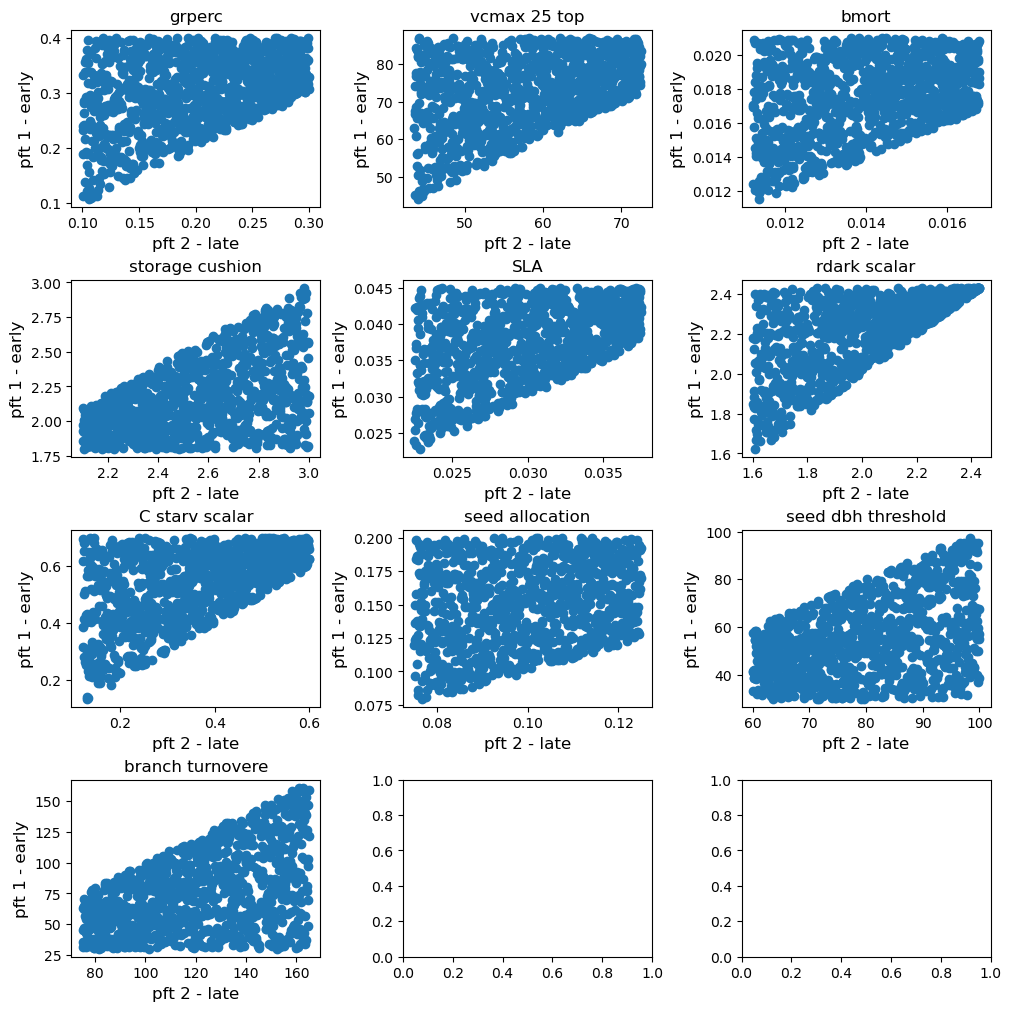

In [10]:
fig, ((fax0,fax1,fax2),(fax3,fax4,fax5), 
      (fax6,fax7,fax8), (fax9,fax10,fax11)) = plt.subplots(nrows=4, ncols=3,figsize=(10,10), constrained_layout=True)

fax0.scatter(samplesdf['fates_grperc2'], df['fates_grperc1'])
fax0.set_title('grperc', fontsize=12)
fax0.set_xlabel('pft 2 - late', fontsize=12)
fax0.set_ylabel('pft 1 - early', fontsize=12)

fax1.scatter(samplesdf['fates_leaf_vcmax25top2'], df['fates_leaf_vcmax25top1'])
fax1.set_title('vcmax 25 top', fontsize=12)
fax1.set_xlabel('pft 2 - late', fontsize=12)
fax1.set_ylabel('pft 1 - early', fontsize=12)

fax2.scatter(samplesdf['fates_mort_bmort2'], df['fates_mort_bmort1'])
fax2.set_title('bmort', fontsize=12)
fax2.set_xlabel('pft 2 - late', fontsize=12)
fax2.set_ylabel('pft 1 - early', fontsize=12)

fax3.scatter(samplesdf['fates_alloc_storage_cushion2'], df['fates_alloc_storage_cushion1'])
fax3.set_title('storage cushion', fontsize=12)
fax3.set_xlabel('pft 2 - late', fontsize=12)
fax3.set_ylabel('pft 1 - early', fontsize=12)

fax4.scatter(samplesdf['fates_leaf_slatop2'], df['fates_leaf_slatop1'])
fax4.set_title('SLA', fontsize=12)
fax4.set_xlabel('pft 2 - late', fontsize=12)
fax4.set_ylabel('pft 1 - early', fontsize=12)

fax5.scatter(samplesdf['fates_maintresp_leaf_vert_scaler_coeff22'], df['fates_maintresp_leaf_vert_scaler_coeff21'])
fax5.set_title('rdark scalar', fontsize=12)
fax5.set_xlabel('pft 2 - late', fontsize=12)
fax5.set_ylabel('pft 1 - early', fontsize=12)

fax6.scatter(samplesdf['fates_mort_scalar_cstarvation2'], df['fates_mort_scalar_cstarvation1'])
fax6.set_title('C starv scalar', fontsize=12)
fax6.set_xlabel('pft 2 - late', fontsize=12)
fax6.set_ylabel('pft 1 - early', fontsize=12)

fax7.scatter(samplesdf['fates_recruit_seed_alloc2'], df['fates_recruit_seed_alloc1'])
fax7.set_title('seed allocation', fontsize=12)
fax7.set_xlabel('pft 2 - late', fontsize=12)
fax7.set_ylabel('pft 1 - early', fontsize=12)

fax8.scatter(samplesdf['fates_recruit_seed_dbh_repro_threshold2'], df['fates_recruit_seed_dbh_repro_threshold1'])
fax8.set_title('seed dbh threshold', fontsize=12)
fax8.set_xlabel('pft 2 - late', fontsize=12)
fax8.set_ylabel('pft 1 - early', fontsize=12)

fax9.scatter(samplesdf['fates_turnover_branch2'], df['fates_turnover_branch1'])
fax9.set_title('branch turnovere', fontsize=12)
fax9.set_xlabel('pft 2 - late', fontsize=12)
fax9.set_ylabel('pft 1 - early', fontsize=12)